<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/7_2_Funci%C3%B3n_de_similitud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Matriz de similitud***

---
---

Última actualización: 28-02-2025.

---
---

# ***Tabla de Contenido***
La mayoría de los puntos en este script se emplearon en el estudio de librerias quimioenfocadas.
- [0 - ***Importar librerias***](#0)
- [1 - ***Lectura de base de datos*** ](#1)
- [2 - ***Selección de función de similitud*** ](#2)
- [3 - ***Gráfico de identidad*** ](#3)
- [4 - ***Referencias*** ](#4)

<a name='0'></a>
# **Librerias: instalar e importar**

In [ ]:
from IPython.utils import io
import tqdm.notebook
import os, os.path, sys, random, subprocess
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
        pbar.update(20)
        #Librerias gráficas
        !pip install matplotlib
        import matplotlib.pyplot as plt
        import matplotlib.font_manager as font_manager
        %matplotlib inline
        import time

        !pip install seaborn
        import seaborn as sns
        pbar.update(40)
        #Librerias del sistema y herramientas primarias:
        import pandas as pd
        import warnings
        warnings.filterwarnings("ignore")
        %config Completer.use_jedi = False
        pbar.update(30)
        #Busqueda
        !pip install rdkit
        from rdkit import Chem, DataStructs
        from rdkit.DataStructs import TanimotoSimilarity, DiceSimilarity, CosineSimilarity
        from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, Descriptors3D, rdMolDescriptors, Scaffolds
        from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol

        PandasTools.RenderImagesInAllDataFrames(images=True) #Para visualizar moléculas
        from rdkit.Chem.Draw import IPythonConsole
        import math
        from math import pi
        from pathlib import Path
        from tempfile import TemporaryDirectory
        !pip install numpy
        import numpy as np
        # Mount Google Drive and upload your PyMOL license
        from google.colab import drive
        drive.mount("/content/drive")
        pbar.update(10)

  0%|          | 0/100 [00:00<?, ?it/s]

<a name='1'></a>
# **1 - Lectura de base de datos**

In [ ]:
url="https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets//08_Similitud_compounds_g9a.csv"
id=pd.read_csv(url,index_col=[0])
id.head()

,molecule_chembl_id,smiles,IC50,std_units,pIC50,molecular_species,heavy_atoms,full_mwt,hbd,hba,psa,rtb,alogp,num_ro5_violations,max_phase,document_chembl_id
0,CHEMBL4170225,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)[nH]3)nc2cc1...,"0,5",nM,"9,301029996",BASE,35.0,477.65,2.0,6.0,65.65,9.0,4.92,0.0,NaN,CHEMBL4130634
1,CHEMBL4162206,COc1cc2c(NC3CCN(C(C)C)CC3)cc(C3CCCCC3)nc2cc1OC...,"0,7",nM,"9,15490196",BASE,37.0,508.75,1.0,6.0,49.86,10.0,6.44,2.0,NaN,CHEMBL4130634
2,CHEMBL3109639,COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C2(C)C,"0,9",nM,"9,045757491",BASE,23.0,317.43,1.0,5.0,60.08,6.0,2.84,0.0,NaN,CHEMBL3108684
3,CHEMBL3109631,COc1cc2c(cc1OCC1CCN(C)C1)N=C(N)C21CCC1,1,nM,9,BASE,23.0,315.42,1.0,5.0,60.08,4.0,2.45,0.0,NaN,CHEMBL3108684
4,CHEMBL5187766,COc1cc2c(NCCN)ccnc2cc1OCCCN1CCCC1,"1,6",nM,"8,795880017",BASE,25.0,344.46,2.0,6.0,72.64,9.0,2.48,0.0,NaN,CHEMBL5113445


In [ ]:
id.sort_values(by=["document_chembl_id"], ascending=False, inplace=True)
id = id.drop_duplicates(subset='molecule_chembl_id')
# Reset index
id.reset_index(drop=True, inplace=True)
print(id.shape)
id[0:3]

(436, 16)


,molecule_chembl_id,smiles,IC50,std_units,pIC50,molecular_species,heavy_atoms,full_mwt,hbd,hba,psa,rtb,alogp,num_ro5_violations,max_phase,document_chembl_id
0,CHEMBL5197586,Nc1ncnc2c1ncn2[C@H]1O[C@@H](CN(CCI)CCC[C@H](N)...,1800,nM,"5,744727495",ZWITTERION,30.0,535.34,5.0,11.0,185.87,10.0,-1.04,2.0,NaN,CHEMBL5136992
1,CHEMBL5172325,Nc1ncnc2c1ncn2[C@H]1O[C@@H](CSCC[C@H](N)C(=O)O...,1500,nM,"5,823908741",ZWITTERION,26.0,384.42,5.0,11.0,182.63,7.0,-1.44,1.0,NaN,CHEMBL5136992
2,CHEMBL5189737,CCC(=O)Nc1cc(NC2CCN(C(C)C)CC2)c2cc(OC)c(OCCCN3...,211,nM,"6,675717545",BASE,36.0,497.68,2.0,7.0,78.96,11.0,4.74,0.0,NaN,CHEMBL5126600


<a name='2'></a>
# **2 - Selección de función de similitud**

In [ ]:

def similarity_calc(smi1, smi2, radius, method='tanimoto'):
    """
    Calcula la similitud entre dos moléculas dadas sus representaciones SMILES.

    Parámetros:
    - smi1 (str): SMILES de la primera molécula.
    - smi2 (str): SMILES de la segunda molécula.
    - radius (int): Radio para la generación de ECFP.
    - method (str): Método de similitud ('tanimoto', 'dice', 'cosine', 'euclidean').

    Retorna:
    - similarity (float): Valor de similitud calculado.
    """

    # Generador de huellas ECFP
    fpgen = AllChem.GetMorganGenerator(radius=radius, fpSize=2048)

    # Convertir SMILES a moléculas
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)

    if mol1 is None or mol2 is None:
        raise ValueError("Una de las moléculas no se pudo cargar correctamente. Verifique los SMILES.")

    # Generar las huellas moleculares
    fp1 = fpgen.GetFingerprint(mol1)
    fp2 = fpgen.GetFingerprint(mol2)

    # Calcular la similitud según el método elegido
    if method == 'tanimoto':
        similarity = round(TanimotoSimilarity(fp1, fp2), 3)

    elif method == 'dice':
        similarity = round(DiceSimilarity(fp1, fp2), 3)

    elif method == 'cosine':
        similarity = round(CosineSimilarity(fp1, fp2), 3)

    elif method == 'euclidean':
        # Convertir las huellas a arrays y calcular la distancia Euclidiana
        arr1 = np.array(fp1)
        arr2 = np.array(fp2)
        similarity = round(np.linalg.norm(arr1 - arr2), 3)

    else:
        raise ValueError("Método no reconocido. Use 'tanimoto', 'dice', 'cosine' o 'euclidean'.")

    return similarity

In [ ]:
#Tomar una muestra aleatoria
id_sample = id.sample(n=100, random_state=1)

tic =time.time()
hmap=pd.DataFrame()
for i in id_sample.index:
    for j in id_sample.index:
        a=id_sample.loc[i].at['smiles']
        b=id_sample.loc[j].at['smiles']
        alignment= similarity_calc(a,b, 3, 'tanimoto')
        hmap.loc[id_sample.loc[i,'molecule_chembl_id'],id_sample.loc[j,'molecule_chembl_id']]=alignment
toc =time.time()
print("Time: "+ str((toc-tic))+" s")
#Matriz de 414x414, con tiempo de ejecución aproximado de: 5 min

Time: 18.696120738983154 s


In [ ]:
#hmap.to_excel('8_compound_aligment.xlsx')
hmap

,CHEMBL3124975,CHEMBL4208812,CHEMBL4294728,CHEMBL1214015,CHEMBL4159604,CHEMBL1214145,CHEMBL4064559,CHEMBL1232432,CHEMBL4084508,CHEMBL5170450,...,CHEMBL3335713,CHEMBL4521601,CHEMBL3621579,CHEMBL4467219,CHEMBL4459846,CHEMBL4173668,CHEMBL1214066,CHEMBL1214068,CHEMBL4292456,CHEMBL4209267
CHEMBL3124975,1.000,0.059,0.147,0.044,0.055,0.042,0.053,0.158,0.043,0.059,...,0.163,0.057,0.157,0.044,0.061,0.053,0.042,0.043,0.136,0.053
CHEMBL4208812,0.059,1.000,0.294,0.279,0.483,0.235,0.221,0.212,0.219,0.412,...,0.028,0.196,0.281,0.262,0.213,0.504,0.260,0.255,0.285,0.440
CHEMBL4294728,0.147,0.294,1.000,0.589,0.318,0.476,0.325,0.479,0.336,0.296,...,0.069,0.417,0.451,0.427,0.403,0.319,0.512,0.521,0.856,0.185
CHEMBL1214015,0.044,0.279,0.589,1.000,0.366,0.670,0.391,0.298,0.406,0.290,...,0.030,0.624,0.326,0.598,0.577,0.365,0.718,0.733,0.670,0.177
CHEMBL4159604,0.055,0.483,0.318,0.366,1.000,0.311,0.307,0.239,0.306,0.513,...,0.021,0.260,0.336,0.347,0.267,0.647,0.331,0.336,0.307,0.234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL4173668,0.053,0.504,0.319,0.365,0.647,0.301,0.297,0.232,0.296,0.496,...,0.020,0.262,0.326,0.346,0.268,1.000,0.331,0.336,0.308,0.254
CHEMBL1214066,0.042,0.260,0.512,0.718,0.331,0.640,0.398,0.336,0.439,0.262,...,0.019,0.579,0.313,0.558,0.552,0.331,1.000,0.782,0.574,0.171
CHEMBL1214068,0.043,0.255,0.521,0.733,0.336,0.651,0.405,0.331,0.434,0.266,...,0.019,0.590,0.318,0.582,0.561,0.336,0.782,1.000,0.583,0.173
CHEMBL4292456,0.136,0.285,0.856,0.670,0.307,0.536,0.302,0.445,0.312,0.287,...,0.063,0.479,0.488,0.488,0.462,0.308,0.574,0.583,1.000,0.175


<a name='1'></a>
# **3 - Gráfico de identidad**

In [ ]:
palette= sns.blend_palette(['black', 'blue','orange'],74)
palette

[(0.0, 0.0, 0.0),
 (0.0, 0.0, 0.023529411764705882),
 (0.0, 0.0, 0.054901960784313725),
 (0.0, 0.0, 0.0784313725490196),
 (0.0, 0.0, 0.10980392156862745),
 (0.0, 0.0, 0.13333333333333333),
 (0.0, 0.0, 0.16470588235294117),
 (0.0, 0.0, 0.18823529411764706),
 (0.0, 0.0, 0.2196078431372549),
 (0.0, 0.0, 0.24313725490196078),
 (0.0, 0.0, 0.27450980392156865),
 (0.0, 0.0, 0.2980392156862745),
 (0.0, 0.0, 0.32941176470588235),
 (0.0, 0.0, 0.3529411764705882),
 (0.0, 0.0, 0.38431372549019605),
 (0.0, 0.0, 0.40784313725490196),
 (0.0, 0.0, 0.4392156862745098),
 (0.0, 0.0, 0.4627450980392157),
 (0.0, 0.0, 0.49411764705882355),
 (0.0, 0.0, 0.5176470588235293),
 (0.0, 0.0, 0.5490196078431373),
 (0.0, 0.0, 0.5725490196078431),
 (0.0, 0.0, 0.6039215686274509),
 (0.0, 0.0, 0.6274509803921569),
 (0.0, 0.0, 0.6588235294117647),
 (0.0, 0.0, 0.6823529411764706),
 (0.0, 0.0, 0.7137254901960784),
 (0.0, 0.0, 0.7372549019607844),
 (0.0, 0.0, 0.7686274509803921),
 (0.0, 0.0, 0.792156862745098),
 (0.0, 0.0, 0.8235294117647058),
 (0.0, 0.0, 0.8470588235294118),
 (0.0, 0.0, 0.8784313725490196),
 (0.0, 0.0, 0.9019607843137255),
 (0.0, 0.0, 0.9333333333333333),
 (0.0, 0.0, 0.9568627450980391),
 (0.0, 0.0, 0.9882352941176471),
 (0.011764705882352941, 0.007612456747404845, 0.9882352941176471),
 (0.043137254901960784, 0.027912341407151098, 0.9568627450980393),
 (0.06666666666666667, 0.043137254901960784, 0.9333333333333333),
 (0.09803921568627451, 0.06343713956170703, 0.9019607843137255),
 (0.12156862745098039, 0.07866205305651673, 0.8784313725490196),
 (0.15294117647058825, 0.098961937716263, 0.8470588235294118),
 (0.17647058823529413, 0.11418685121107268, 0.8235294117647058),
 (0.20784313725490197, 0.13448673587081894, 0.792156862745098),
 (0.23137254901960785, 0.1497116493656286, 0.7686274509803921),
 (0.2627450980392157, 0.17001153402537486, 0.7372549019607844),
 (0.28627450980392133, 0.1852364475201844, 0.7137254901960787),
 (0.3176470588235294, 0.20553633217993078, 0.6823529411764706),
 (0.3411764705882353, 0.2207612456747405, 0.6588235294117647),
 (0.37254901960784315, 0.24106113033448676, 0.6274509803921569),
 (0.396078431372549, 0.25628604382929643, 0.603921568627451),
 (0.42745098039215684, 0.2765859284890427, 0.5725490196078431),
 (0.45098039215686275, 0.2918108419838524, 0.5490196078431373),
 (0.4823529411764706, 0.3121107266435986, 0.5176470588235293),
 (0.5058823529411764, 0.3273356401384083, 0.49411764705882355),
 (0.5372549019607841, 0.3476355247981544, 0.46274509803921593),
 (0.5607843137254902, 0.36286043829296427, 0.4392156862745098),
 (0.592156862745098, 0.3831603229527105, 0.40784313725490196),
 (0.615686274509804, 0.3983852364475202, 0.38431372549019605),
 (0.6470588235294118, 0.41868512110726647, 0.3529411764705882),
 (0.6705882352941176, 0.4339100346020761, 0.3294117647058824),
 (0.7019607843137254, 0.45420991926182236, 0.29803921568627456),
 (0.7254901960784313, 0.46943483275663206, 0.27450980392156865),
 (0.7568627450980392, 0.4897347174163783, 0.2431372549019608),
 (0.7803921568627451, 0.504959630911188, 0.2196078431372549),
 (0.8117647058823529, 0.5252595155709343, 0.18823529411764706),
 (0.8352941176470589, 0.540484429065744, 0.16470588235294115),
 (0.8666666666666667, 0.5607843137254902, 0.1333333333333333),
 (0.8901960784313725, 0.5760092272202999, 0.1098039215686275),
 (0.9215686274509803, 0.5963091118800461, 0.07843137254901966),
 (0.9450980392156862, 0.6115340253748558, 0.05490196078431375),
 (0.9764705882352941, 0.6318339100346021, 0.02352941176470591),
 (1.0, 0.6470588235294118, 0.0)]

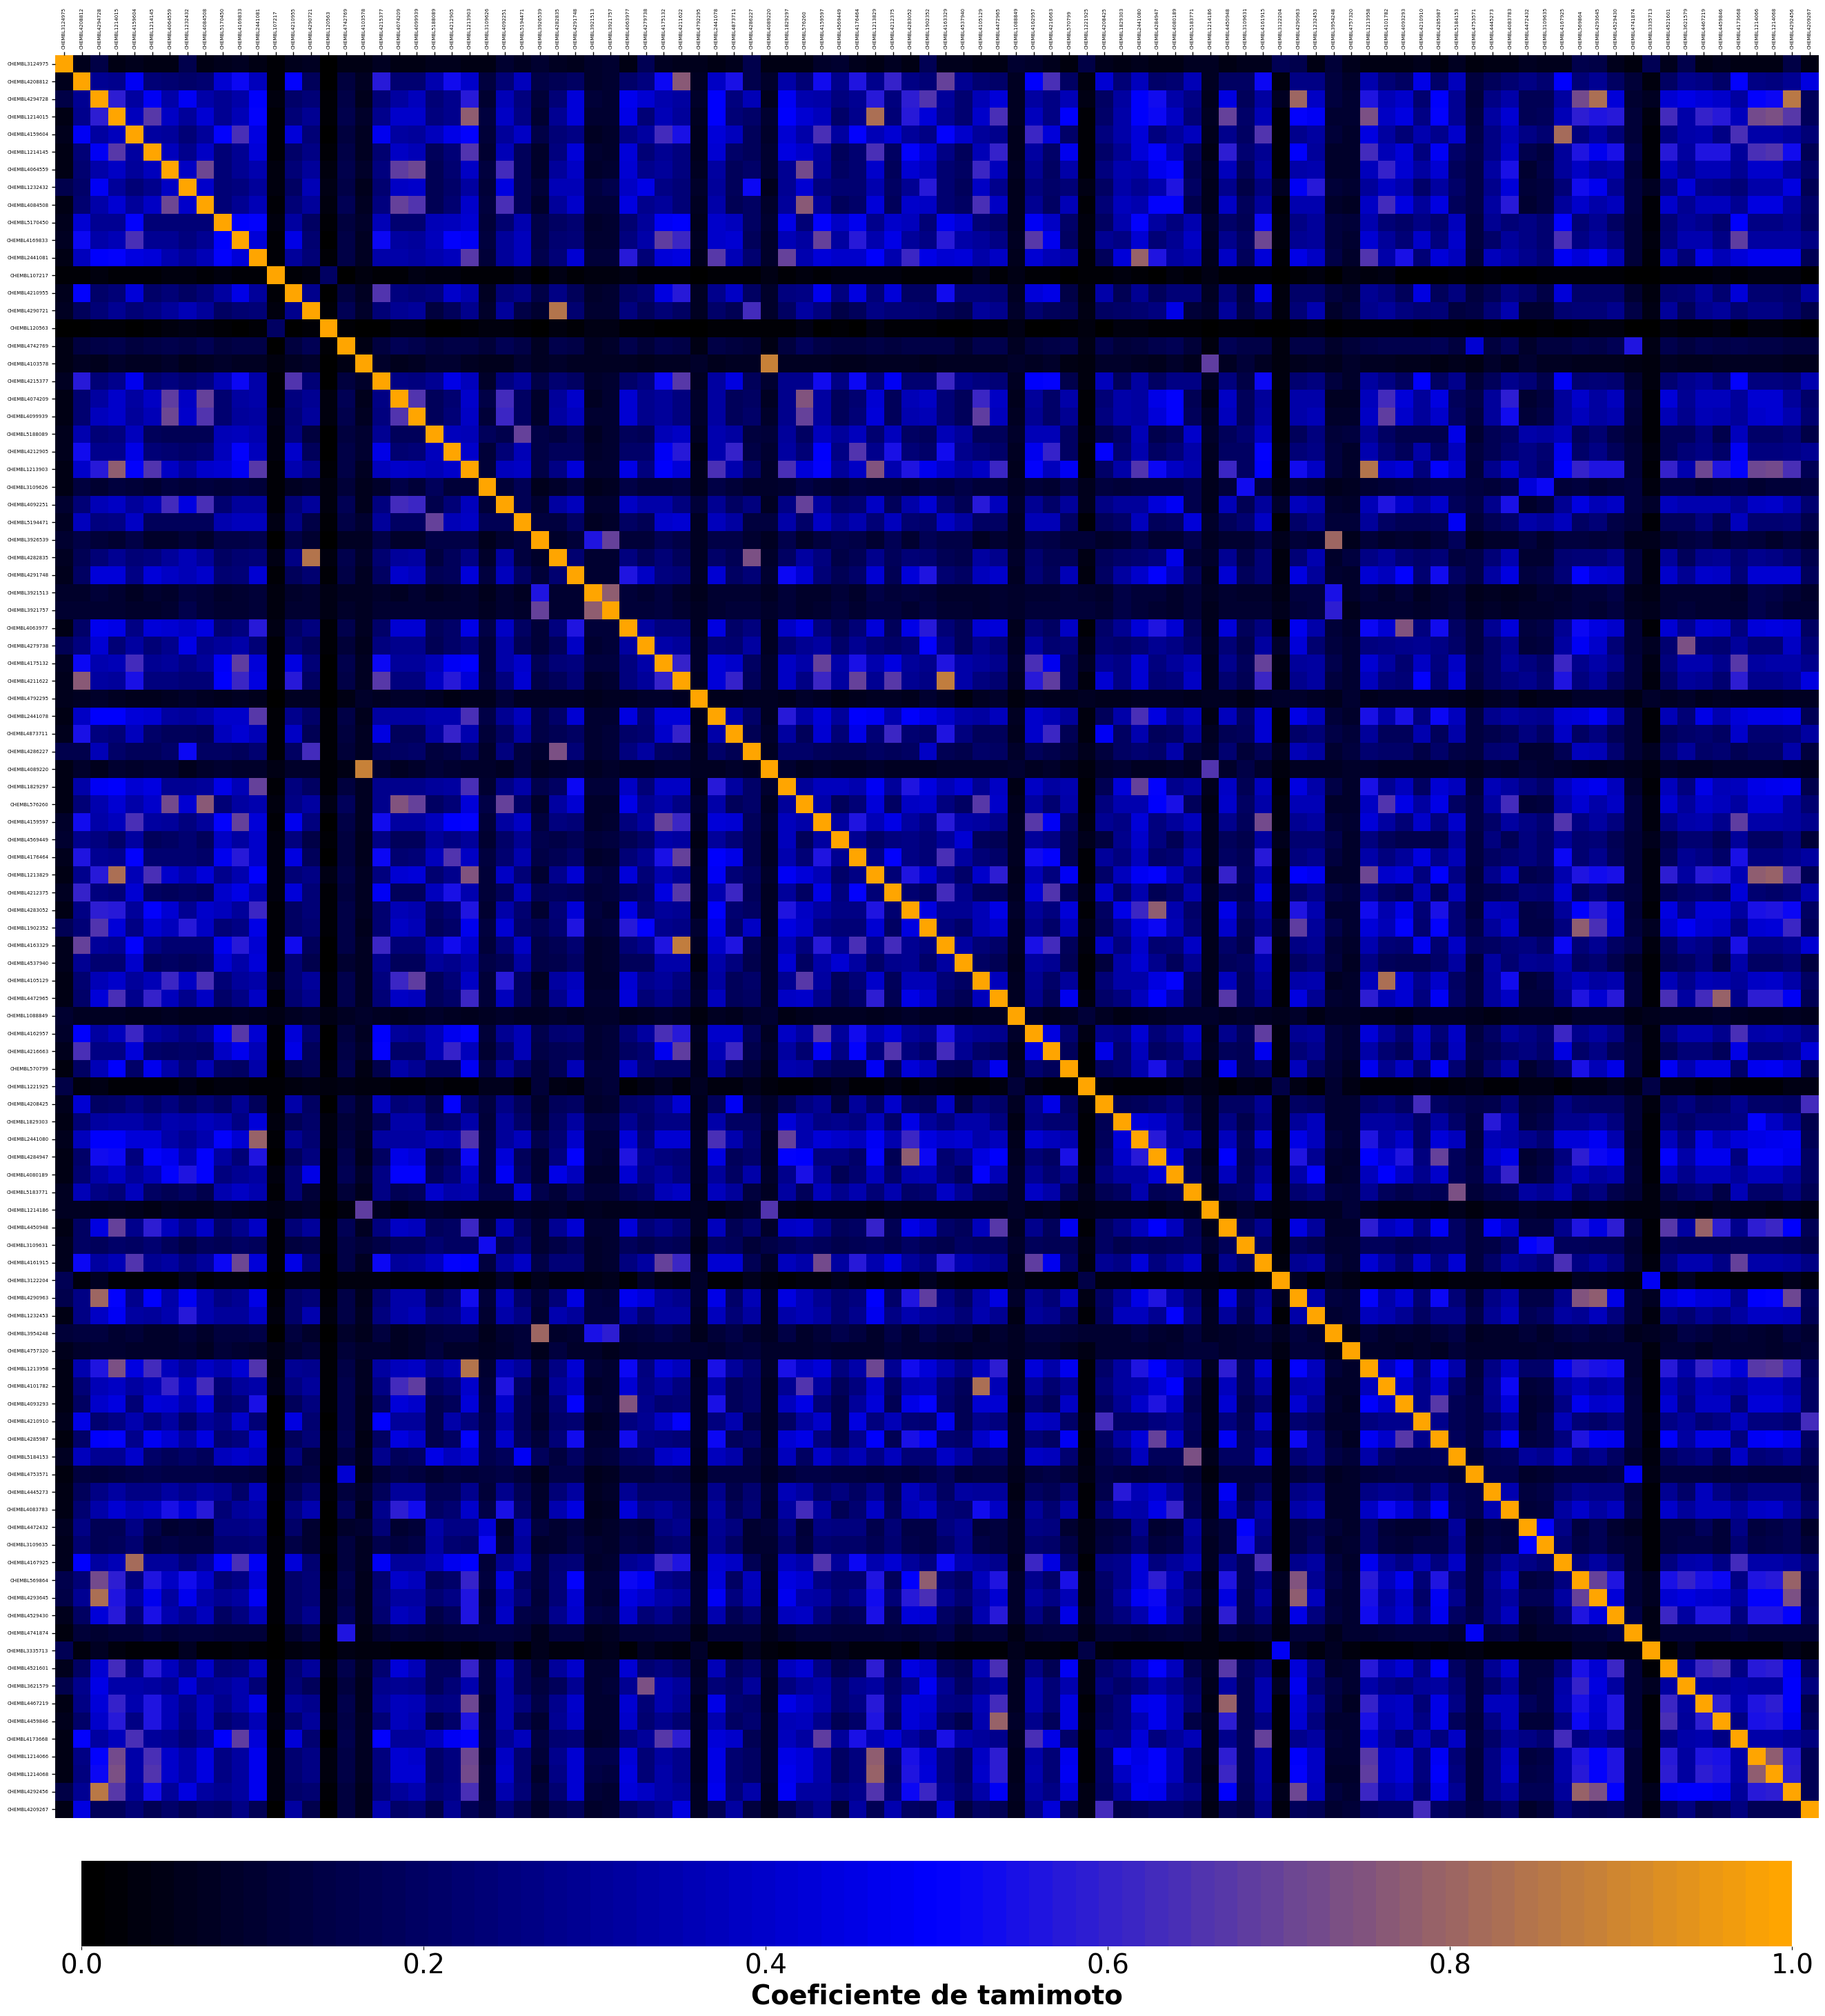

In [ ]:
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(hmap,square = True, xticklabels=hmap.columns, yticklabels=hmap.index, cmap=palette, vmin=0, vmax=1,
            cbar_kws={'shrink':0.8,
                      'orientation':'horizontal','spacing':'uniform',
                      'pad':0.02})
ax.figure.axes[1].tick_params(axis="x", labelsize=28) #Tamaño de ticks en cbar
ax.figure.axes[1].set_xlabel('Coeficiente de tamimoto', size=28, weight='bold') #Etiqueta de cbar
ax.tick_params(labelsize=28)
plt.xticks (np.arange(len(hmap.index))+0.5, hmap.index,rotation=90)
plt.yticks (np.arange(len(hmap.columns))+0.5, hmap.columns, rotation=0)
ax.xaxis.tick_top()
plt.tick_params ('both',width=1,labelsize=5)
#plt.savefig('Coeficiente_tanimoto.png',dpi=300,format='png',transparent=False)
plt.show()

<a name='4'></a>
# **4 - Referencias:**

1.   https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html
2.   https://gist.github.com/leelasd/746f3c447805fc6ea5aad1071bd77aef

*   https://github.com/rdkit/UGM_2014/blob/master/Notebooks/Scaffold%20analysis%20of%20ChEMBL%20data%20with%20pandas%20and%20RDKit/Scaffold%20analysis%20of%20ChEMBL%20data%20with%20pandas%20and%20RDKit%20-%20RDKit%20UGM2014.ipynb
*   https://github.com/rdkit/UGM_2013/blob/master/Tutorials/pandastools/Pandas_RDKit_UGM.ipynb
*https://github.com/rdkit/UGM_2013/blob/master/Tutorials/pandastools/Pandas_RDKit_UGM.ipynb

